# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import numpy as np
from dqn_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import torch

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [3]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

Episode 100	Average Score: 1.13
Episode 200	Average Score: 4.96
Episode 300	Average Score: 6.94
Episode 400	Average Score: 9.99
Episode 500	Average Score: 13.42
Episode 600	Average Score: 14.44
Episode 700	Average Score: 15.38
Episode 800	Average Score: 14.66
Episode 900	Average Score: 15.53
Episode 1000	Average Score: 15.28
Episode 1100	Average Score: 15.70
Episode 1200	Average Score: 15.73
Episode 1254	Average Score: 16.02
Environment solved in 1154 episodes!	Average Score: 16.02


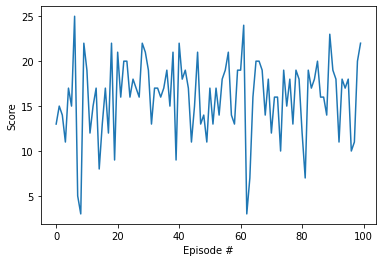

In [5]:
def run_dqn_episode(agent, env, brain_name, eps, is_training):
    """Run the DQN agent for one episode"""
    env_info = env.reset(train_mode=is_training)[brain_name]    # reset the environment
    state = env_info.vector_observations[0]                     # get the current state
    score = 0                                                   # initialize the score
    while True:
        action = agent.act(state, eps)                          # select an action
        action = action.astype(int)
        env_info = env.step(action)[brain_name]                 # send the action to the environment
        next_state = env_info.vector_observations[0]            # get the next state
        reward = env_info.rewards[0]                            # get the reward
        done = env_info.local_done[0]                           # see if episode has finished
        if is_training:
            agent.step(state, action, reward, next_state, done) # compute a step for the agent
        score += reward                                         # update the score
        state = next_state                                      # roll over the state to next time step
        if done:                                                # exit loop if episode finished
            return score

def dqn(env, brain_name, n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, finish_score=16.0):
    """Deep Q-Learning.
    
    Params
    ======
        env (UnityEnvironment): unity environment
        brain_name (str): used brain name in the enviroment
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        finish_score (float): maximum average score to reach before exiting the learning loop and save the checkpoint 
    """
    agent = Agent(state_size=37, action_size=4, seed=0)
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        score = run_dqn_episode(agent, env, brain_name, eps, is_training=True)
        scores_window.append(score)       # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=finish_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores_window

scores = dqn(env, brain_name)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Run this cell to try the obtained checkpoint over 100 episodes. This takes a lot of times to run.

In [6]:
import os

if os.path.isfile('checkpoint.pth'):
    agent = Agent(state_size=37, action_size=4, seed=0)
    scores = []
    # load the weights from file
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    for i_episode in range(100):
        score = run_dqn_episode(agent, env, brain_name, eps=0, is_training=False)
        scores.append(score)       # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)), end="")
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(100, np.mean(scores)))
else:
    print('No checkpoint was found! Rerun the cell above with a finish score between 13 and 16 to make a new checkpoint.')

Episode 100	Average Score: 16.23


When finished, you can close the environment.

In [7]:
env.close()